In [8]:
# Cell 1: Python
# Setup: Imports and Global Configurations
import music21 as m21
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import os
import glob
import time # For timing operations
import tqdm

# Configure plots for better readability
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("viridis") # Setting a nice color palette
FIG_SIZE = (12, 6) # Default figure size for plots
SMALL_FIG_SIZE = (10, 4)

# Path to the MAESTRO dataset (assuming it's in a 'data/' subdirectory)
# IMPORTANT: Replace with the actual path to your unzipped MAESTRO dataset
MAESTRO_DATA_PATH = '../data/' # Or 'data/maestro-v2.0.0', etc.

# For reproducibility of any sampling, though less critical for EDA
# np.random.seed(42)

print(f"Music21 version: {m21.__version__}")
print(f"Pandas version: {pd.__version__}")
print(f"Numpy version: {np.__version__}")
print(f"Matplotlib version: {plt.matplotlib.__version__}")
print(f"Seaborn version: {sns.__version__}")

Music21 version: 9.5.0
Pandas version: 2.2.3
Numpy version: 1.26.4
Matplotlib version: 3.10.1
Seaborn version: 0.13.2


In [9]:
METADATA_FILE = os.path.join(MAESTRO_DATA_PATH, 'maestro-v3.0.0.csv')

# Load the metadata
metadata_df = None
try:
    metadata_df = pd.read_csv(METADATA_FILE)
    print("Successfully loaded metadata.")
    print("First 5 rows of the metadata:")
    print(metadata_df.head())
    print(f"\nShape of metadata: {metadata_df.shape}")
    print("\nColumns in metadata:")
    print(metadata_df.columns)
except FileNotFoundError:
    print(f"Error: Metadata file not found at {METADATA_FILE}")
    print("Please ensure the MAESTRO dataset (v3.0.0 or compatible) is downloaded, unzipped,")
    print("and the 'maestro-v3.0.0.csv' file is located in the 'data/' directory.")
    # In a real script, one might raise an exception or exit here.
    # For a notebook, execution might continue, but subsequent cells will fail.
except Exception as e:
    print(f"An error occurred while loading the metadata: {e}")

# Proceed with analysis only if metadata_df is loaded
if metadata_df is not None:
    # Further analysis code will go here
    pass

Successfully loaded metadata.
First 5 rows of the metadata:
   canonical_composer                canonical_title       split  year  \
0          Alban Berg                   Sonata Op. 1       train  2018   
1          Alban Berg                   Sonata Op. 1       train  2008   
2          Alban Berg                   Sonata Op. 1       train  2017   
3  Alexander Scriabin  24 Preludes Op. 11, No. 13-24       train  2004   
4  Alexander Scriabin               3 Etudes, Op. 65  validation  2006   

                                       midi_filename  \
0  2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...   
1  2008/MIDI-Unprocessed_03_R2_2008_01-03_ORIG_MI...   
2  2017/MIDI-Unprocessed_066_PIANO066_MID--AUDIO-...   
3  2004/MIDI-Unprocessed_XP_21_R1_2004_01_ORIG_MI...   
4  2006/MIDI-Unprocessed_17_R1_2006_01-06_ORIG_MI...   

                                      audio_filename    duration  
0  2018/MIDI-Unprocessed_Chamber3_MID--AUDIO_10_R...  698.661160  
1  2008/MIDI-Unprocessed


Dataset Split Counts:
split
train         962
test          177
validation    137
Name: count, dtype: int64

Total Duration (seconds) per Split:
split
test           71927.921195
train         573277.442251
validation     69946.183203
Name: duration, dtype: float64
Total dataset duration: 198.65 hours

Number of Unique Composers (Overall):
Total unique composers: 60

Table 1: MAESTRO Dataset Split Summary
        Split  Number of MIDI files  Total Duration (hours)  Number of Unique Composers
0       train                   962                  159.24                          58
1  validation                   137                   19.43                          16
2        test                   177                   19.98                          16


/var/folders/h6/w7dmj13j7w3d94l9lzcsbgr40000gn/T/ipykernel_4007/4146810422.py:48: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=metadata_df, x='split', order=plot_order, palette="viridis")


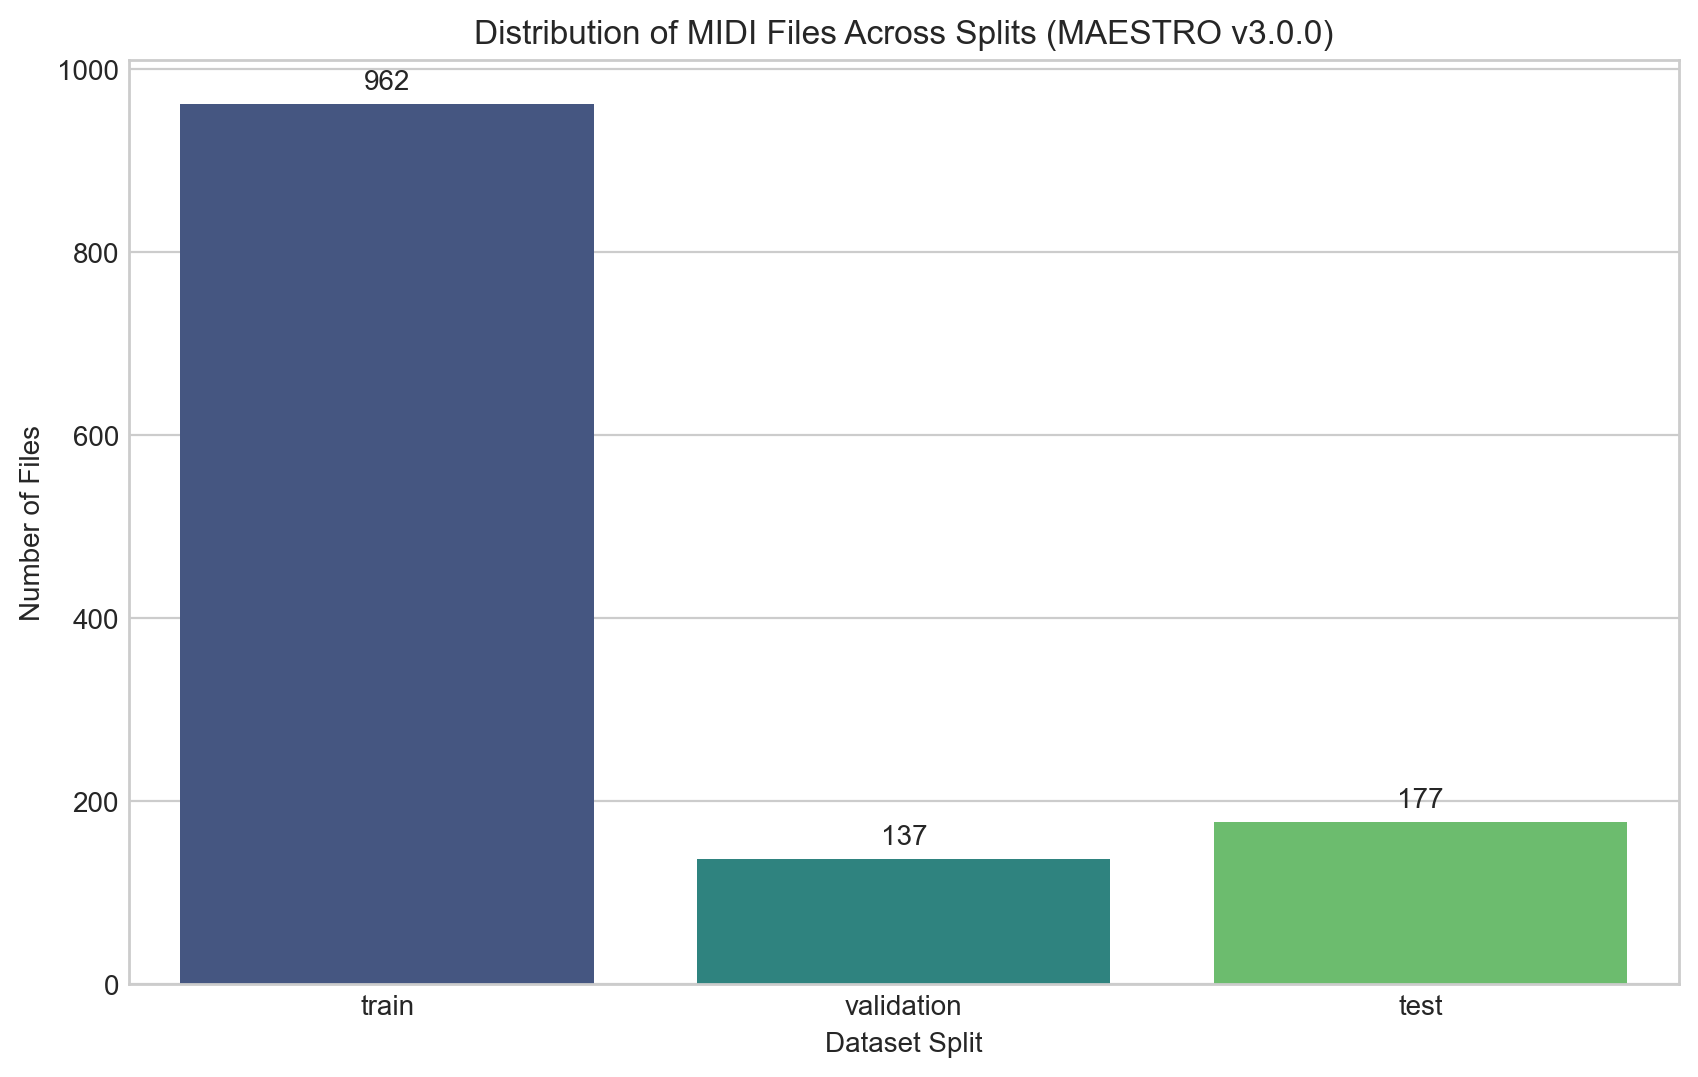

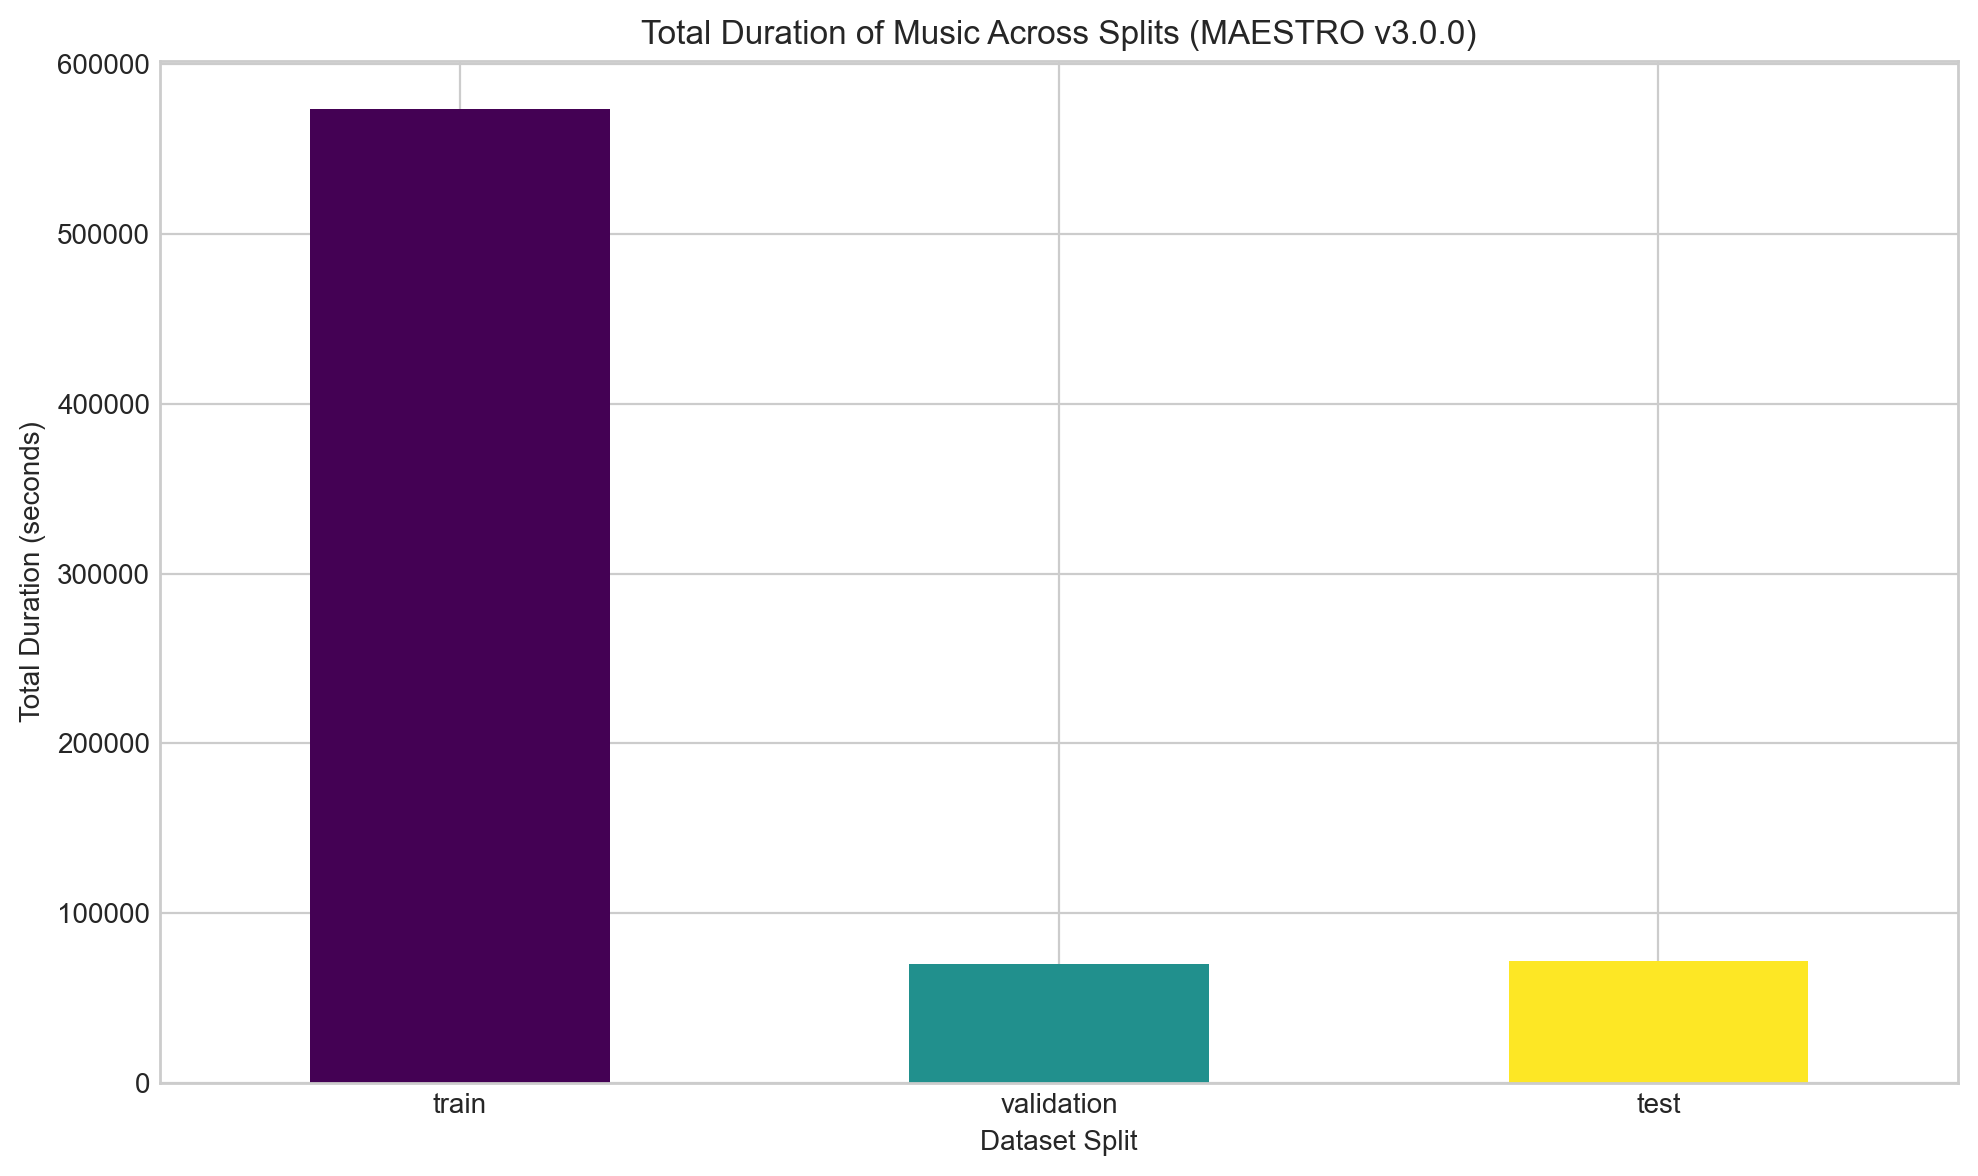

In [11]:
if metadata_df is not None:
    print("\nDataset Split Counts:")
    split_counts = metadata_df['split'].value_counts()
    print(split_counts)

    print("\nTotal Duration (seconds) per Split:")
    duration_per_split = metadata_df.groupby('split')['duration'].sum()
    print(duration_per_split)
    total_duration_hours = metadata_df['duration'].sum() / 3600
    print(f"Total dataset duration: {total_duration_hours:.2f} hours") # Approx 200 hours

    print("\nNumber of Unique Composers (Overall):") # Changed title slightly for clarity
    unique_composers_total = metadata_df['canonical_composer'].nunique()
    print(f"Total unique composers: {unique_composers_total}")

    # Preparing data for Table 1
    # Ensure the order for table creation, then explicitly re-order
    # 'train', 'validation', 'test' will be the final order in table1_df
    table1_data = {
        'Split': split_counts.index, # Initial order based on value_counts
        'Number of MIDI files': split_counts.values,
        'Total Duration (hours)': (duration_per_split.reindex(split_counts.index).values / 3600).round(2)
        # Used .reindex() on duration_per_split to safely align with split_counts.index order
    }
    table1_df = pd.DataFrame(table1_data).set_index('Split').loc[['train', 'validation', 'test']].reset_index() # Ensure final order

    # Add unique composers per split
    unique_composers_per_split = metadata_df.groupby('split')['canonical_composer'].nunique()

    # --- CORRECTED MERGE OPERATION ---
    table1_df = table1_df.merge(
        unique_composers_per_split.rename('Number of Unique Composers'), # This Series will be the right table
        left_on='Split',      # Use the 'Split' column from the left DataFrame (table1_df)
        right_index=True,     # Use the index from the right Series (unique_composers_per_split)
        how='left'            # Use 'left' to keep all rows from table1_df and match composers
    )
    # Ensure the new column is integer and NaNs (if any) are 0
    if 'Number of Unique Composers' in table1_df.columns:
        table1_df['Number of Unique Composers'] = table1_df['Number of Unique Composers'].fillna(0).astype(int)

    print("\nTable 1: MAESTRO Dataset Split Summary")
    print(table1_df.to_string()) # Using to_string() for potentially better console alignment

    # Plotting split distribution
    plt.figure(figsize=(10, 6))
    # Ensure the plotting order is consistent
    plot_order = ['train', 'validation', 'test']
    sns.countplot(data=metadata_df, x='split', order=plot_order, palette="viridis")
    plt.title('Distribution of MIDI Files Across Splits (MAESTRO v3.0.0)')
    plt.ylabel('Number of Files')
    plt.xlabel('Dataset Split')
    # Make sure to get counts in the specified plot_order for annotations
    counts_for_plot = split_counts.reindex(plot_order).fillna(0)
    for i, count in enumerate(counts_for_plot):
        plt.text(i, count + (0.01 * counts_for_plot.max()), str(int(count)), ha='center', va='bottom') # Dynamic offset
    plt.show()

    # Plotting duration distribution per split
    plt.figure(figsize=(10, 6))
    duration_per_split.reindex(plot_order).fillna(0).plot(kind='bar', color=['#440154', '#21908d', '#fde725'])
    plt.title('Total Duration of Music Across Splits (MAESTRO v3.0.0)')
    plt.ylabel('Total Duration (seconds)')
    plt.xlabel('Dataset Split')
    plt.xticks(rotation=0)
    plt.tight_layout() # Adjust layout
    plt.show()
else:
    print("Metadata not loaded. Skipping statistical analysis and plotting.")